# Learning Multi-Experiment Networks from High-Dimensional Point Process Data -- the Statistical Inference Procedure

## Generate Multi-Experiment Point Processes

### Generate connectivity matrix

As preparation, generate both the connectivity matrix (3-dimensional (M,p,p) array) and the background rate (2-dimensional (M,p) array). Please refer to functions save file: **genSetting.py**

In [2]:
import numpy as np
from genSetting import genCircleStarThreeNetworks
print_max  = lambda x : np.round( np.max( abs(np.real(x) ) ) , 2)

U, Beta= genCircleStarThreeNetworks(m=10,star_coef =0.6, circle_coef = 0.6, U_coef=0.1)
M = U.shape[0]
# make sure the max eigen value is bounded by 1; otherwise, the point processes may not be stable.
'max eigen value of Connectivity Matrix:', [print_max( Beta[m]) for m in range(M)]

('max eigen value of Connectivity Matrix:', [0.6, 0.6, 0.6])

### Visualize true network structures

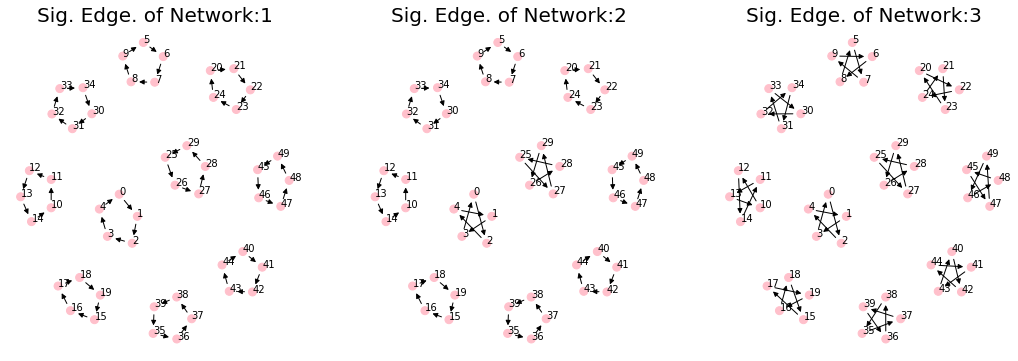

In [3]:
from igraph import *
import matplotlib.pyplot as plt 
from util import plot_graph
layout = plot_graph( Beta  )

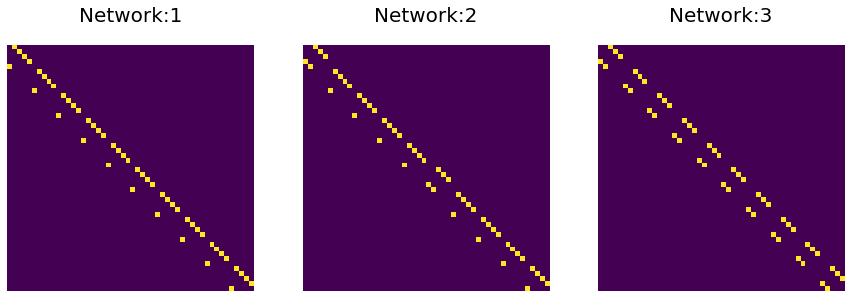

In [4]:
# instead of illustrating in graph, we can also illustrate the connectivity matrix 
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(Beta[m]!=0)
    axs[m].set_title('Network:'+ str(m+1) ,fontsize=20)

### Generate spike train data 

Spike train data is a type of point process data that is often referred in neuroscience. It records the spiking activity of neurons. Here we generate spike train data from a network of multiple neurons/point processes. In particular, Given the connectivity matrix and the background intensity rate as inputs, we generate spike train data from p processes under M experiment. The function **simu_net** is saved in **simu_net.py**

In [5]:
from simu_net import simu_net

T =  [1000,1000,1000] # 
rho, rate, lag = 2, 1, 1
M = Beta.shape[0]
p = Beta.shape[1]

np.random.seed(123)
DATA = simu_net( T, # length of each experiment, array of length M
                M, # no. experiments
                p, # no. processes
                Beta, U, # connectivity matrix and the background intensity rate
                rho , rate, lag # parameter used for transition kernel 
               )
Spike = DATA['Spike'] # output Spike, the spike train data, is a dictionary of length M with its value a p x p matrix
Phi = DATA['Phi'] # output Phi, the transition matrix, is a dictionary of length M with its value a p x p matrix

## Network Inference

The key function, **net_inf**, conducting inference for each of the multi-experiment networks are saved in **net_inf.py**. The function provides p-values in testing each edge of each networks, using the de-correlated score test. **net_inf** requires input of the spike train data, saved as dictionary where each item is a data matrix at each experiment. 

In [5]:
from net_inf import net_inf

### Inference with default transition kernel (exp decay) and model coefficeint estimation by joint network estimation

In this part, we call **net_inf** to make inference over the edges of each network. Without giving the design matrix and any estimated connectivity coefficients, the function create default design matrix using expoenential decay transition kernel, and estimate the connectivity coefficeints using the joint network estimation procedure.

In [7]:
V,PVAL, LCI, UCI = net_inf( Y= Spike   # outcome, dict, for all experiments
                            #X = None , # design matrix, dict, default None, created using exponential decay
                            #COEF=None , # 3D-array estimated coefficents, (M,p,p+1),if not given, est. using lasso
                            #msg = False # show progress of iterations
                          )

In [ ]:
# decide edges based on p-values from the inference procedure 
alpha = 0.01
Edges = (PVAL < alpha)*1.0

fig, axs = plt.subplots(1, 3,figsize=(18, 6))
     
for m in range(M):
    axs[m].axis('off')
     
    g = Graph.Adjacency(Edges[m])

    plot(g,  layout = layout ,              
             vertex_color='pink', 
             vertex_label = np.arange(Edges[m].shape[0]), 
             vertex_size = 8, 
             target= axs[m] )

    axs[m].set_title('Sig. Edge. of Network:'+ str(m+1) ,fontsize=20)

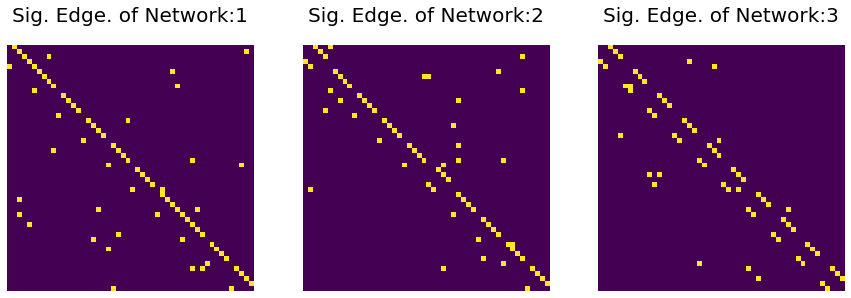

In [8]:
# illustrate in connectivity matrix format

fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range( M):
    axs[m].axis('off')
    axs[m].matshow(PVAL[m] <alpha)
    axs[m].set_title('Sig. Edge. of Network:'+ str(m+1) ,fontsize=20)

### Advanced options: inference with pre-specificed model coefficeints

In this part, we call **net_inf** to make inference over the edges of each network using the estimated connectivity coefficeints (e.g. via separate or joint estimation). 

#### Using the estimated model coefficients from joint network estimation procedure

We first estimate the connectivity coefficients using the joint estimation procedure. For more detailed description on how to use **net_est**, please see **demo_network_estimation**. 

**net_inf** has an opton **COEF** that takes in the pre-estimated connectivity coefficents. 

In [9]:
from net_est_auto import net_est 
EST_ALL = net_est( Y=Spike)
BETA_EST = EST_ALL['BETA_EST']
U_EST = EST_ALL['U_EST']

In [10]:
COEF_EST =  np.array( [ np.column_stack( [ U_EST[m] , BETA_EST[m]] )  for m in range(M) ] )

V,PVAL, LCI, UCI = net_inf( Y= Spike , COEF = COEF_EST )

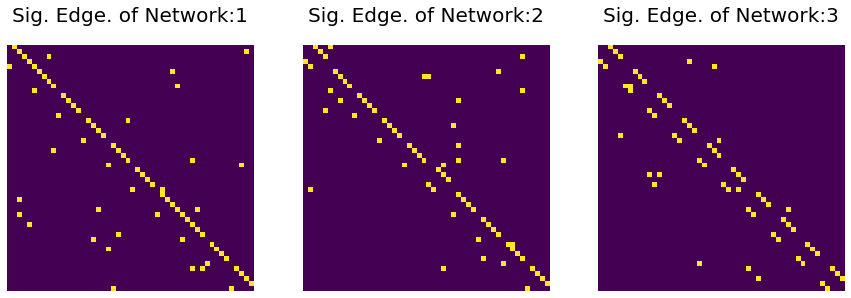

In [11]:
# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range( M):
    axs[m].axis('off')
    axs[m].matshow(PVAL[m] < alpha)
    axs[m].set_title('Sig. Edge. of Network:'+ str(m+1) ,fontsize=20)

### Advanced options: fast inference using threholding

**net_inf** makes inference over all edges in the networks. The computation becomes unmanageable when the network size is large. **net_inf_threshold**, the thresholding method, mitigates this issue by identifying the sub-graphs of the network in the first step and then applying **net_inf** to each sub-graph. 

[Chen et al (2016)](https://digital.lib.washington.edu/researchworks/handle/1773/37044) has  shown that  the  connected  components  of  the  true  network  can  be consistently  identified  using  the  empirical  cross-covariances. In practice, we use a hybrid thresholding that generates sub-graphs based on the empirical cross-covariances matrices ([Tang et al (2015)](https://link.springer.com/chapter/10.1007/978-3-319-23525-7_36) ). In the case when the network is composed by a few small sub-graphs, using threholding method will be much faster.  

In [6]:
from net_inf_threshold  import net_inf_threshold

In [7]:
V, PVAL, LCI, UCI = net_inf_threshold( Y=Spike, lag= 1, lambda1=0.2, lambda2 = 0, msg =True  )

start subgraph... 1 ...out of total 10
start subgraph... 2 ...out of total 10
start subgraph... 3 ...out of total 10
start subgraph... 4 ...out of total 10
start subgraph... 5 ...out of total 10
start subgraph... 6 ...out of total 10
start subgraph... 7 ...out of total 10
start subgraph... 8 ...out of total 10
start subgraph... 9 ...out of total 10
start subgraph... 10 ...out of total 10


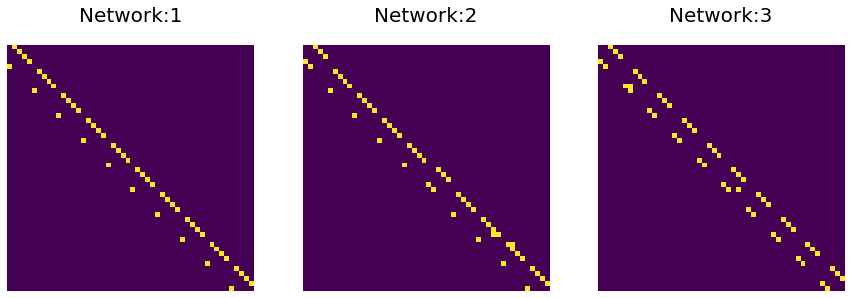

In [8]:
# instead of illustrating in graph, we can also illustrate the connectivity matrix 
alpha = 0.01
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range( PVAL.shape[0]):
    axs[m].axis('off')
    axs[m].matshow(  1.0*(PVAL[m] <alpha) )
    axs[m].set_title('Network:'+ str(m+1), fontsize=20)